# 1. Preparing Tool Box

In [3]:
import os
for dirname, _, filenames in os.walk('\pkbhx\data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

\pkbhx\data\pkbhx.csv


In [4]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn import model_selection
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_squared_error
from tpot import TPOTRegressor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

# 2. Reading the Data

In [5]:
# Create a DataFrame
data = pd.read_csv('\pkbhx\data\pkbhx.csv', sep=';')

In [65]:
# Is there any null values?
print(data.isnull().values.any())

False


# 3. Data Cleaning and Pre-processing

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  993 non-null    object 
 1   pK_BHX  993 non-null    float64
dtypes: float64(1), object(1)
memory usage: 15.6+ KB


count    993.000000
mean       1.145760
std        0.992671
min       -1.710000
25%        0.480000
50%        1.140000
75%        1.940000
max        4.150000
Name: pK_BHX, dtype: float64


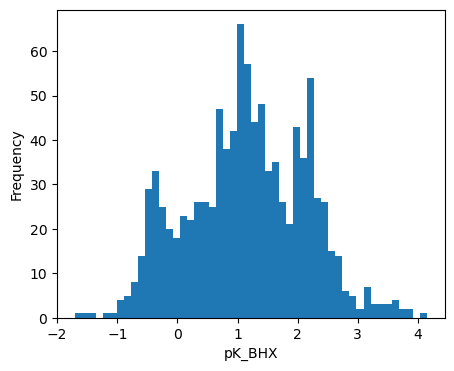

In [89]:
print(data['pK_BHX'].describe())

fig, ax = plt.subplots(figsize=(5, 4))
ax.set_ylabel('Frequency')
ax.set_xlabel('pK_BHX')
data['pK_BHX'].hist(bins=50,ax=ax,grid=False)
plt.show()

In [6]:
# There might be one or more valid SMILES that can represent one compound
# Generate Canonical SMILES
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

In [7]:
Canon_SMILES = canonical_smiles(data.SMILES)
# len(Canon_SMILES)

# Put the smiles in the dataframe
data['SMILES'] = Canon_SMILES

In [35]:
# Analyzing the duplicates
print(f'{data.duplicated().sum()} duplicated records in {len(data)} total records.\n',
      f'Resulting in {data.duplicated().sum()/len(data)*100:.1f}% of duplicated records.')

0 duplicated records in 993 total records. Resulting in 0.0% of duplicated records.


In [8]:
# The RDKit package calculates the molecular descriptors
# for all molecules using as input the SMILE representation.
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
rdkit_2d_desc = []
for k in range(len(data)):
  header = calc.GetDescriptorNames()
  d = calc.CalcDescriptors(Chem.MolFromSmiles(data.iloc[k, 0]))
  rdkit_2d_desc.append(d)

temp_df = pd.DataFrame(rdkit_2d_desc, columns=header)  

data = pd.concat([data, temp_df], axis=1)

In [41]:
print(data.isnull().values.any())

True


In [42]:
data[data.isnull().any(axis=1)]

,SMILES,pK_BHX,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
697,c1ccc(C[Se](Cc2ccccc2)=[O:1])cc1,3.30,11.990193,-1.770000,11.990193,0.731879,0.785197,277.225,263.113,278.020986,...,0,0,0,0,0,0,0,0,0,0
698,C[Se](C)=[O:1],3.43,9.652778,-1.291667,9.652778,1.291667,0.434580,125.029,118.981,125.958386,...,0,0,0,0,0,0,0,0,0,0
839,c1ccc(P(c2ccccc2)(c2ccccc2)=[Se:1])cc1,0.94,3.550556,-1.651435,3.550556,1.372593,0.507427,341.252,326.132,342.007658,...,0,0,0,0,0,0,0,0,0,0
847,c1ccc([As](c2ccccc2)(c2ccccc2)=[O:1])cc1,4.15,13.878819,-3.544896,13.878819,0.933356,0.675029,322.239,307.119,322.033887,...,0,0,0,0,0,0,0,0,0,0
903,C[Se:1]C,-0.01,2.187500,0.875000,2.187500,0.875000,0.403159,109.030,102.982,109.963471,...,0,0,0,0,0,0,0,0,0,0


In [9]:
header = list(data.columns)

si = SimpleImputer(missing_values=np.nan, strategy='mean')
si = si.fit(data.drop(columns='SMILES'))

data_si = pd.DataFrame(si.transform(data.drop(columns='SMILES')))

data = pd.concat([data['SMILES'], data_si], axis=1)
data.columns = header

In [47]:
print(data.isnull().values.any())

False


In [10]:
data.drop(columns=['SMILES'], inplace=True)

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Columns: 209 entries, pK_BHX to fr_urea
dtypes: float64(209)
memory usage: 1.6 MB


In [101]:
data.head(5)

,pK_BHX,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.90,10.605370,0.058426,10.605370,0.058426,0.523744,121.139,114.083,121.052764,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.78,5.006944,0.888889,5.006944,0.888889,0.434057,87.122,78.050,87.068414,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.67,3.263889,1.212963,3.263889,1.212963,0.473722,103.190,94.118,103.045570,36.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.10,3.185185,1.166667,3.185185,1.166667,0.457255,89.163,82.107,89.029920,30.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.56,5.098194,0.913194,5.098194,0.913194,0.423889,101.149,90.061,101.084064,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
data_y = data['pK_BHX']
data_X = data.drop(columns=['pK_BHX'])

In [116]:
'''features = []
for col in data_X.columns:
    features.append(col)'''

In [11]:
corr = data.corr()[['pK_BHX']]

In [15]:
corr

,pK_BHX
pK_BHX,1.000000
MaxEStateIndex,0.241487
MinEStateIndex,-0.067413
MaxAbsEStateIndex,0.241487
MinAbsEStateIndex,-0.108424
...,...
fr_thiazole,0.008342
fr_thiocyan,-0.013305
fr_thiophene,-0.052665
fr_unbrch_alkane,0.047319


In [49]:
# Split Data into Training (80%) and Test set (20%)

X_train, X_test, y_train, y_test = model_selection.train_test_split(data_X, data_y, test_size=0.2, random_state=0)

In [51]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

rmse = make_scorer(rmse, greater_is_better=False)

In [59]:
t0 = time.time()
tpot_classifier = TPOTRegressor(generations=5, population_size=1, scoring=rmse, verbosity=2, random_state=0)
tpot_classifier.fit(X_train.values, y_train)
ttt = time.time() - t0
print(f'Time executing TPOT (seconds): {ttt}')
tpot_classifier.export('/pkbhx/data/tpot_exported_pipeline_g5_p1.py')

Optimization Progress:   0%|          | 0/6 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.4182386466835178

Generation 2 - Current best internal CV score: -0.25146134931798125

Generation 3 - Current best internal CV score: -0.23930337761427783

Generation 4 - Current best internal CV score: -0.23930337761427783

Generation 5 - Current best internal CV score: -0.23930337761427783

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=1.0, min_samples_leaf=5, min_samples_split=17, n_estimators=100)
Time executing TPOT (seconds): 33.34491753578186
